In [1]:
from matplotlib import pyplot as plt
import os
import cv2 #import OpenCV

def show_image_mask_mask(img, mask,out, cmap='gray'): # function shows image and 2 masks 
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 3, 1,label='image')
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 3, 2,label='mask')
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 3, 3,label='predicted mask')
    plt.imshow(out, cmap=cmap)
    plt.axis('off')

def show_image_mask(img, mask, cmap='gray'): # known function that shows an image and a mask
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')


data_dir = './data/'

#show_image_mask(img, label*20, cmap='gray')
#plt.pause(1)


Matplotlib is building the font cache; this may take a moment.


In [2]:
from torch.utils.data import DataLoader
import torch,numpy as np
import torch.utils.data as data
import cv2
import os
from glob import glob
import albumentations as A



In [3]:
# m = cv2.imread('data/train/labels/PV01_324951_1203793_label.bmp',0)

In [4]:
#m.shape

In [5]:
#np.unique(m)

In [6]:
#show_image_mask(m,m)

In [7]:
#mask0 = (m==0)

In [8]:
#mask1 = (m>0)

In [9]:
#show_image_mask_mask(m,mask0*255,mask1*255)

In [10]:
#np.array([mask0,mask1]).shape

In [11]:
#for i in range(3):
#    transformed =  transform(image=img,mask=label)
#    show_image_mask(transformed['image'], transformed['mask'], cmap='gray')

In [12]:
from albumentations.pytorch import ToTensorV2
transform = A.Compose([
    A.RandomCrop(256,256,always_apply=True, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),max_pixel_value=255.0, p=1.0),
    ToTensorV2(),
    
])


class TrainDataset(data.Dataset):
    def __init__(self, root='./data/train'):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'*.bmp'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'labels',basename[:-4]+'_label.bmp'))
            

    def __getitem__(self, index):
            global transform
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
            label = cv2.imread(mask_path,0)
            #mask0 = (label==0)
            #mask1 = (label>0)
            #label_processed = np.array([mask0,mask1])
            
            transformed =  transform(image=data,mask=label)
            #print(transformed['mask'], transformed['mask'].shape)
            mask0 = (transformed['mask'] == 0)
            mask1 = (transformed['mask'] > 0)
            ll = np.array([mask0.numpy(),mask1.numpy()],dtype=np.uint8)
            #print(ll.shape,np.unique(ll))
            label_processed = torch.from_numpy(ll)

            return transformed['image'],label_processed
        
    def __len__(self):
        return len(self.img_files)
    
    
class ValDataset(data.Dataset):
    def __init__(self, root='./data/test'):
        super(ValDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'*.bmp'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'labels',basename[:-4]+'_label.bmp'))
            

    def __getitem__(self, index):
            global transform
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
            label = cv2.imread(mask_path,0)
            #mask0 = (label==0)
            #mask1 = (label>0)
            #label_processed = np.array([mask0,mask1])
            
            transformed =  transform(image=data,mask=label)
            #print(transformed['mask'], transformed['mask'].shape)
            mask0 = (transformed['mask'] == 0)
            mask1 = (transformed['mask'] > 0)
            ll = np.array([mask0.numpy(),mask1.numpy()],dtype=np.uint8)
            #print(ll.shape,np.unique(ll))
            label_processed = torch.from_numpy(ll)

            return transformed['image'],label_processed

    def __len__(self):
        return len(self.img_files)

In [38]:
import segmentation_models_pytorch as smp

model = smp.PAN(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [39]:
import matplotlib.pyplot as plt
def plot_losses(epoch_train_losses=[], epoch_val_losses=[]): 
    plt.plot(epoch_train_losses,label='train')
    plt.plot(epoch_val_losses,label='val')
    #plt.plot(eval_cpu_percents,label='Eval')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper left")
    plt.savefig('loss.png')
    plt.clf()

In [ ]:
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

#model=torch.load('u-effb4_100.pth')
model.to(device)

epochs = 50

num_workers = 2
batch_size = 4
train_set = TrainDataset()
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

val_set = ValDataset()
val_data_loader = data.DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)



loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn_2 = smp.losses.DiceLoss('binary', classes=None, log_loss=True, from_logits=True,ignore_index=None, eps=1e-08)
loss_fn_3 = smp.losses.FocalLoss('binary', alpha=None, gamma=3.0, ignore_index=None, reduction='mean', normalized=False, reduced_threshold=None)
train_loss=[]


opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
#opt = torch.optim.Adam(model.parameters(), lr=0.008)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')
best_loss = 50
val_loss = []
for epoch in range(epochs):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    counter = 0
    for image,mask in training_data_loader:
        
        #image.to(device)
        #mask.to(device)
        counter += 1
        image = image.to(device)
        mask = mask.to(device)
        mask = torch.unsqueeze(mask,1)
        #print(image.shape,image.dtype,mask.shape,mask.dtype)
        #print(image.shape)
        out = model(image)
        #print(out.shape,out.dtype)
        loss = loss_fn_3(out,mask.float())
        opt.zero_grad()
        loss.backward()
        opt.step()

        # print statistics - epoch and loss
        running_loss += loss.item()
        #print(running_loss)
        #break
        
    epoch_loss = running_loss/counter    
    train_loss.append(epoch_loss)
    print(epoch_loss,' - train loss for epoch ',epoch)
    model.eval()
    val_losser = 0.0
    for (i,(image, mask)) in enumerate(val_data_loader):
        image = image.to(device)
        mask = mask.to(device)
        mask = torch.unsqueeze(mask,1)
        #print(image.shape)
        out = model(image)
        #print(out.shape)
        loss = loss_fn_3(out,mask.float())
        val_losser += loss.item()
        #break
    val_epoch_loss = val_losser/(i+1)
    print(val_epoch_loss,' - Val loss for epoch ',epoch)
    val_loss.append(val_epoch_loss)

    if val_epoch_loss < best_loss:
        print('saving best model at epoch ',epoch)
        torch.save(model,'pan-eff_best.pth')
        best_loss = val_epoch_loss
    
    time.sleep(1)
    if epoch%10 == 0:
        torch.save(model,'pan-eff_chckpnt.pth')
        
    
        
    
        
print('Finished Training')
#plot_losses(train_loss,val_loss)
#torch.save(model,'u-effb4_100.pth')
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='val')
#plt.plot(eval_cpu_percents,label='Eval')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper left")
plt.savefig('loss.png')



The current device is cuda:0


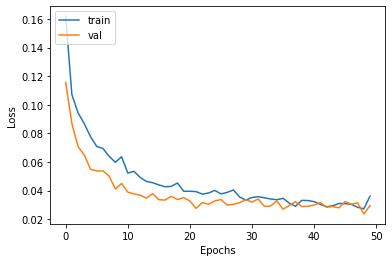

In [32]:

plt.plot(train_loss,label='train')
plt.plot(val_loss,label='val')
#plt.plot(eval_cpu_percents,label='Eval')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper left")
plt.savefig('loss.png')